In [1]:
# import packages
import numpy as np

import matplotlib.pyplot as plt
## set global font size
plt.rcParams.update({'font.size':18})

import time
import lzma, pickle
import scipy.fft as fft
import scipy.integrate as integ
import scipy.interpolate as interp
import scipy.optimize as optimize

import astropy.units as u
from astropy import constants as const

import rebound

Goal: recreate Figure 7.1(b) in Murray & Dermott, and recover the mode frequencies and amplitudes.

In [2]:
sim = rebound.Simulation()
sim.units = ('yr', 'AU', 'Msun')
date = '1983-01-01 00:00:00'

sim.add(['Sun', 'Jupiter', 'Saturn'], date=date)

# Rotate the axes so that z points along the total angular momentum.
rot = rebound.Rotation.to_new_axes(newz=sim.angular_momentum())
sim.rotate(rot)

# save initial inclinations (in deg)
j_inc_0 = sim.particles[1].inc * (180/np.pi)
s_inc_0 = sim.particles[2].inc * (180/np.pi)
inc_0 = np.asarray((j_inc_0, s_inc_0))

print("Jupiter initial (relative) inc = {:.2f} deg".format(j_inc_0))
print("Saturn initial (relative) inc = {:.2f} deg".format(s_inc_0))

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Jupiter initial (relative) inc = 0.36 deg
Saturn initial (relative) inc = 0.89 deg


# Analytical derivation of mode freqs and amps

I check that the mode frequency formula (Su & Lai 2022, Equation A2) matches our simulation's frequencies.

In [3]:
def laplace_coeff_integrand(x, alpha):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). Following Eq. A3 in Su & Lai 2022, we
    use j=1 and s=3/2. The result is used in the laplace_coeff function.
    
    PARAMETERS
    ----------
    x: argument of the function
    alpha: variable that isn't integrated over
    
    '''
    
    num = np.cos(x) # numerator
    denom = (1 - 2 * alpha * np.cos(x) + alpha**2) ** (3/2)
    
    return num / denom

def laplace_coeff(alpha):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.
    (This is the exact form of Eq. A3 in Su & Lai 2022.) The result is used 
    in mode_freq (and is denoted as "b").
    
    PARAMETERS
    ----------
    alpha: input to the formula.
    
    '''
    
    return 1 / np.pi * integ.quad(laplace_coeff_integrand, 0, 2*np.pi, args=(alpha))[0]
    
def mode_freq(a_j, a_k, m_k, M_star):
    
    '''
    
    Calculate the precession rate (w_jk) of the j-th planet 
    induced by the k-th planet.
    
    PARAMETERS
    ----------
    a_j, a_k: semimajor axes of planets j and k, respectively; assumes that
    parameters are provided with units (e.g., u.au or u.m)
    m_k, M_star: masses of planet k and the central star, respectively; assumes
    that parameters are provided with units (e.g., u.kg or u.M_sun)
    
    '''
    # np.min, max don't work with astropy quantities
    a_min, a_max = a_j, a_k
    if (a_k < a_j):
        a_min = a_k
        a_max = a_j
        
    n_j = np.sqrt(const.G * M_star / (a_j**3))
    alpha = a_min / a_max
    b = laplace_coeff(alpha)
    
    return m_k / (4 * M_star) * \
            (a_j * a_min) / (a_max**2) * \
            n_j * b

In [4]:
# my original values
a_jup = 5.2038 * u.au
a_sat = 9.5826 * u.au
m_jup = 0.000954588 * u.M_sun
m_sat = 0.0002857 * u.M_sun
M_sun = 1. * u.M_sun

# Yubo's values
# a_jup = 5.202 * u.au
# a_sat = 9.537 * u.au
# m_jup = 0.000954 * u.M_sun   
# m_sat = 0.000286 * u.M_sun    
# M_sun = 1. * u.M_sun

# calculate w_jk values in yr^-1 (but without the unit)
w_js = mode_freq(a_jup, a_sat, m_sat, M_sun).to(u.yr**-1).value
w_sj = mode_freq(a_sat, a_jup, m_jup, M_sun).to(u.yr**-1).value

mat = np.array([
    [-w_js, w_js],
    [w_sj, -w_sj]
])

eigs, eigvs = np.linalg.eig(mat)
prec_freq = eigs[np.where(np.abs(eigs) > 1e-10)]
prec_eigv = eigvs[:, np.where(np.abs(eigs) > 1e-10)]
prec_eigv = np.squeeze(prec_eigv).T # reshape to (2,), ie each row is an eigv
zero_mode_ind = np.where(np.abs(eigs) < 1e-10)[0] # index of mode w/ frequency=0

# Note: for 2 planets, prec_freq = -(w_js + w_sj)
print(f'Period: {np.round(2 * np.pi / (-prec_freq), 3)} years')
print(f'Non-zero mode frequencies: {prec_freq}')
print(f'Corresponding mode eigenvectors: {prec_eigv}')

Period: [51658.853] years
Non-zero mode frequencies: [-0.00012163]
Corresponding mode eigenvectors: [-0.37628948  0.92650215]


In [5]:
prec_freq * 1e4

array([-1.21628433])

In [6]:
# check that eigenvalues and eigenvectors match
print(f"Matrix \"divided\" by eigenvector: {np.matmul(mat, np.squeeze(prec_eigv)) / prec_eigv}")
print(f'Eigenvalues: {eigs}')

Matrix "divided" by eigenvector: [-0.00012163 -0.00012163]
Eigenvalues: [ 0.         -0.00012163]


## Mode amplitudes 

Calculate mode amplitudes given the initial inclination vector $\vec{I}_0$ (which has $n$ entries) and the eigenvectors. 

Let $n$ be the number of planets. The eigenvalue problem can be written as:

$$ \frac{d\vec{I}}{dt} = \sum_{i=1}^{n-1} g_i \left(\vec{I}_0 \cdot \frac{\vec{v}_i}{|\vec{v}_i|}\right)\vec{v}_i = \sum_{i=1}^{n-1} g_i \left(\vec{I}_0 \cdot \vec{v}_i\right)\vec{v}_i \equiv \sum_{i=1}^{n-1} g_i \vec{A}_i.$$

The second-to-last step comes from the fact that the eigenvectors are normalized, so $|\vec{v}_i| = 1$. The goal is to find the $n-1$ mode amplitudes, each of which is defined as $\vec{A}_i = \left(\vec{I}_0 \cdot \vec{v}_i\right)\vec{v}_i$.

To get the inclination variation for a given planet $n$, we take the $n$th component of the above equation:

$$ \frac{dI_n}{dt} = \sum_{i=1}^{n-1} g_i \left(I_{0, n} v_{i, n}\right)v_{i,n} \equiv \sum_{i=1}^{n-1} g_i A_{i,n}.$$



In [15]:
def get_mode_amps(complex_inc_0, eigvs, zero_mode_ind):
    '''
    Given the initial inclination vector complex_inc_0 and the set of 
    eigenvectors (eigvs) for a system, compute the mode amplitudes 
    (which are the projections of inc_0 onto the eigenvectors). NOTE: In the below
    calculation, the eigenvector with eigenvalue 0 is set to the zero vector.
    (The index of this eigenvector is given by zero_mode_ind.)
    
    Let n be the number of planets. inc_0 has shape (n,), and eigvs has shape
    (n, n), where the columns (i.e. eigvs[:,i]) are the eigenvectors. The output 
    will have shape (n, n), and the ith column corresponds to mode amplitude i.
    (The column at A_vecs[:,zero_mode_ind] will be the zero vector.)
    
    
    '''
    
    n = len(complex_inc_0)
    complex_inc_0 = np.expand_dims(complex_inc_0, axis=1) # change shape to (n, 1)
    eigvs[:,zero_mode_ind] = np.zeros((n, 1))
    
    scalars = np.matmul(np.conj(complex_inc_0.T), eigvs) # complex inner product 
    diag_mat = np.zeros((n,n), dtype=complex)
    np.fill_diagonal(diag_mat, scalars)
    A_vecs = 1j * np.matmul(eigvs, diag_mat)
    
    print(f'inc_0.T: {inc_0}')
    print(f'scalars: {scalars}')
    print(f'diag_mat: {diag_mat}')
    
    return A_vecs

In [12]:
eigvs

array([[ 0.        , -0.37628948],
       [ 0.        ,  0.92650215]])

In [18]:
# initial values for complex inc
j_complex_inc0 = sim.particles[1].inc * np.exp(1j * sim.particles[1].Omega)
s_complex_inc0 = sim.particles[2].inc * np.exp(1j * sim.particles[2].Omega)
j_complex_inc0_deg = j_complex_inc0 * 180 / np.pi
s_complex_inc0_deg = s_complex_inc0 * 180 / np.pi

complex_inc_0 = np.asarray([j_complex_inc0_deg, s_complex_inc0_deg])
mode_amps = get_mode_amps(complex_inc_0, eigvs, zero_mode_ind)
print('Mode amplitudes:')
print(mode_amps)
print('Magnitudes of mode amplitudes:')
print(np.abs(mode_amps))

inc_0.T: [0.36104365 0.89021439]
scalars: [[0.        +0.j         0.89523226-0.34841523j]]
diag_mat: [[0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.89523226-0.34841523j]]
Mode amplitudes:
[[ 0.        +0.j         -0.13110499-0.33686648j]
 [ 0.        +0.j          0.32280746+0.82943461j]]
Magnitudes of mode amplitudes:
[[0.         0.36147966]
 [0.         0.89003731]]


This is slightly inconsistent with the numerical results, interestingly enough.

# Numerical derivation of mode freqs and amps

In [ ]:
tstep = 1
tmax = 2**18 # end time of integration (yr)
num_steps = int(tmax / tstep)

In [ ]:
j_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Jupiter over the sim
s_complex_incs_rad = np.asarray([0. + 0.j] * num_steps) # complex inc (radians) of Saturn over the sim
times = np.linspace(0, tmax, num_steps)

start = time.time()
for i, t in enumerate(times):
    inc_j = sim.particles[1].inc
    inc_s = sim.particles[2].inc
    
    # update complex inclination arrays
    Omega_i_j = sim.particles[1].Omega
    Omega_i_s = sim.particles[2].Omega
    j_complex_incs_rad[i] = inc_j * np.exp(1j * Omega_i_j)
    s_complex_incs_rad[i] = inc_s * np.exp(1j * Omega_i_s)
    
    # move forward by one timestep
    sim.integrate(t)

print(f'Integration took {np.round(time.time() - start, 1)} seconds')

In [ ]:
# convert inclinations from radians to degrees
j_complex_incs_deg = j_complex_incs_rad * (180 / np.pi)
s_complex_incs_deg = s_complex_incs_rad * (180 / np.pi)

# save incs
file_path = f'j_s_complex_incs_%.1E_yrs.pkl' % tmax
with lzma.open(file_path, 'wb') as f:
    pickle.dump((times, j_complex_incs_deg, s_complex_incs_deg), f)

In [ ]:
j_complex_incs_deg.real[:10]

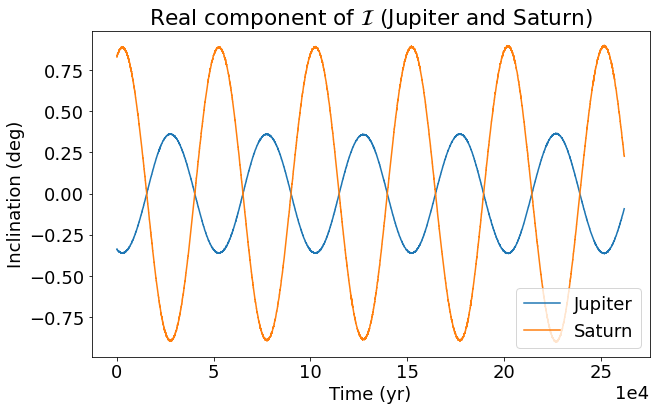

In [5]:
load_data = True

if load_data:
    tstep = 1
    tmax = 2**18 # end time of integration (yr)
    num_steps = int(tmax / tstep)
    N = num_steps

    file_path = f'j_s_complex_incs_%.1E_yrs.pkl' % tmax

    ## open old data files
    with lzma.open(file_path, 'rb') as f:
        times, j_complex_incs_deg, s_complex_incs_deg = pickle.load(f)

fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')

plt.plot(times[1:], j_complex_incs_deg.real[1:], label='Jupiter')
plt.plot(times[1:], s_complex_incs_deg.real[1:], label='Saturn')

plt.xlabel('Time (yr)')
plt.ticklabel_format(axis='x', style='sci', scilimits=(4,4)) # time axis in terms of 1e4 yr
plt.ylabel('Inclination (deg)')
plt.title('Real component of $\mathcal{I}$ (Jupiter and Saturn)')
plt.legend(loc='lower right')

plt.savefig("Figures/JS_inc_series.png", bbox_inches='tight')
plt.show()

# Decompose into sine waves

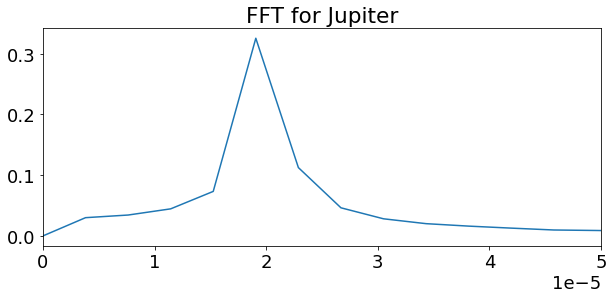

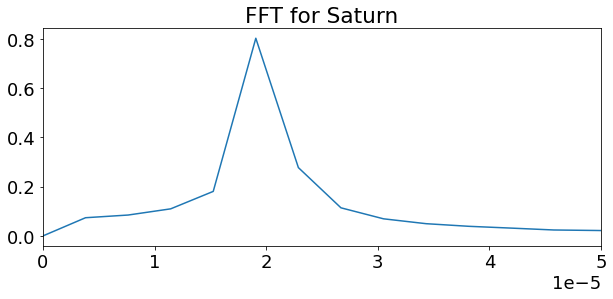

Jupiter freq: 1.907e-05 years^-1
Jupiter period: 52428.80 years
Jupiter amplitude: 0.325 deg

Saturn freq: 1.907e-05 years^-1
Saturn period: 52428.80 years
Saturn amplitude: 0.802 deg


In [6]:
def quad_fn(coeffs, x):
    '''
    Given the coefficients of a quadratic polynomial f(x), return f(x).
    
    PARAMETERS
    ----------
    coeffs: 3-element list containing the quadratic's coefficients, 
    highest power first.
    x: the value at which to evaluate f(x).
    
    '''
    
    a, b, c = coeffs
    
    return a * x**2 + b * x + c

def FFT_freq_amp(incs, planet_name, quad_interp=False):
    '''
    Given a time series (incs) representing either component of complex inclination, 
    return the frequency and amplitude of the time series. Includes an option
    to apply quadratic interpolation around the FFT's peak.
    
    NOTE: This implementation is for 2 planets.
    
    ARGUMENTS
    ---------
    incs: time series of either the real or imag component of a complex inclination series
    planet_name: string representing planet name (used in plots)
    quad_interp: if True, uses quadratic interpolation to improve the result
    of low-resolution FFTs; default is False
    
    '''
    
    # only look at the positive side of the FFT
    yf = np.abs(fft.fft(incs - np.mean(incs))[:N//2])
    yf_scaled = 2 / num_steps * np.abs(yf)
    xf = fft.fftfreq(num_steps, tstep)[:N//2]
    
    # plot FFT result
    plt.figure(figsize=(10,4))
    plt.plot(xf, yf_scaled)
    plt.xlim(0, 5e-5)
    plt.title('FFT for ' + planet_name)
    plt.show()
    
    # run quadratic interpolation on the FFT
    if quad_interp:
        x_vals = [xf[np.argmax(yf) - 1], xf[np.argmax(yf)], xf[np.argmax(yf) + 1]]
        y_vals = np.abs([yf[np.argmax(yf) - 1], yf[np.argmax(yf)], yf[np.argmax(yf) + 1]])
        y_vals_scaled = 2 / num_steps * np.abs(y_vals)

        # get coefficients of the interpolated quadratic function
        coeffs = np.polyfit(x_vals, y_vals_scaled, deg=2)
        a, b, c = coeffs

        # get mode freq and amplitude
        mode_f = - b / (2*a) # peak of the quadratic function
        mode_amp = quad_fn(coeffs, mode_f)

        # return period (years) and amplitude
        return mode_f, mode_amp

    # (result from no quadratic interpolation)
    # return freq (years) and amplitude (degrees)
    return xf[np.argmax(yf)], yf_scaled[np.argmax(yf)]

# first values in data arrays are weird
j_series = j_complex_incs_deg.real[1:]
s_series = s_complex_incs_deg.real[1:]
times = times[1:]

use_interp = False
j_freq, j_amp = FFT_freq_amp(j_series, 'Jupiter', quad_interp=use_interp)
j_period = 1/j_freq # years
s_freq, s_amp = FFT_freq_amp(s_series, 'Saturn', quad_interp=use_interp)
s_period = 1/s_freq # years

if use_interp:
    print('WITH QUADRATIC INTERPOLATION:')
print(f'Jupiter freq: %0.3e years^-1' % j_freq)
print(f'Jupiter period: %0.2f years' % j_period)
print(f'Jupiter amplitude: %0.3f deg' % j_amp)
print()
print(f'Saturn freq: %0.3e years^-1' % s_freq)
print(f'Saturn period: %0.2f years' % s_period)
print(f'Saturn amplitude: %0.3f deg' % s_amp)

Mode amp: [0.37587572 0.92667008]


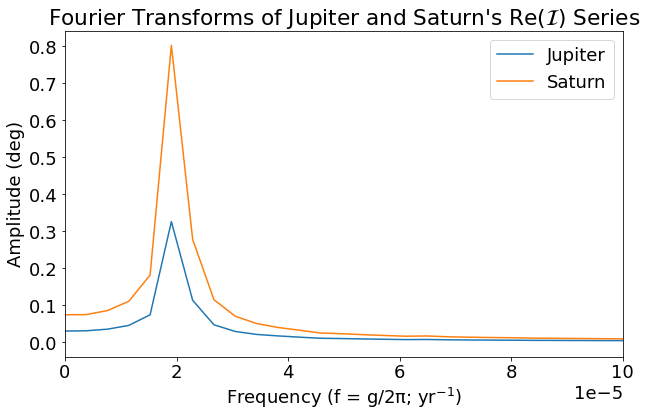

In [7]:
j_fft = 2 / num_steps * np.abs(fft.fft(j_complex_incs_deg.real))
j_fft = j_fft[:N//2]
s_fft = 2 / num_steps * np.abs(fft.fft(s_complex_incs_deg.real))
s_fft = s_fft[:N//2]

max_freq = np.argmax(j_fft)
freqs = fft.fftfreq(num_steps, tstep)[:N//2]

mode_amp = np.array([j_fft[max_freq], s_fft[max_freq]])
mode_amp = mode_amp / np.linalg.norm(mode_amp)
print(f'Mode amp: {mode_amp}')

# plot FTs
fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')

plt.plot(freqs, j_fft, label='Jupiter')
plt.plot(freqs, s_fft, label='Saturn')

plt.xlabel('Frequency (f = g/2π; yr$^{-1}$)')
plt.xlim(0, 1e-4)
plt.ticklabel_format(axis='x', style='sci', scilimits=(-5,-5))

plt.ylabel('Amplitude (deg)')

plt.title("Fourier Transforms of Jupiter and Saturn's Re($\mathcal{I}$) Series")
plt.legend()

fig_path = "Figures/JS_FTs.png"
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

## Apply `symfit`

In [16]:
def test_func(x, a, b, c):
    '''
    Returns a sin function a*sin(bx + c).
    
    '''
    
    return a * np.sin(b * x + c)

In [17]:
from symfit import variables, parameters, Model, Fit, sin

t, b_inc, c_inc = variables('t, b_inc, c_inc')
g1, A11, A21, phi1, phi2 = parameters('g1, A11, A21, phi1, phi2')
# set initial guesses for the parameters
g1.value = 2*np.pi*j_freq
A11.value = j_amp
A21.value = s_amp
phi1.value = -np.pi/2
phi2.value = np.pi/2

# model each inclination series as a sum of sinusoids
model = Model({
    b_inc: A11 * sin(g1*t + phi1),
    c_inc: A21 * sin(g1*t + phi2),
})

fit = Fit(model, t=times, b_inc=j_series, c_inc=s_series)
fit_result = fit.execute()
params = fit_result.params
print(params)

OrderedDict([('A11', 0.3614900367860608), ('A21', 0.8911741672748523), ('g1', 0.0001262477125356155), ('phi1', -1.936399645421727), ('phi2', 1.205193216384236)])


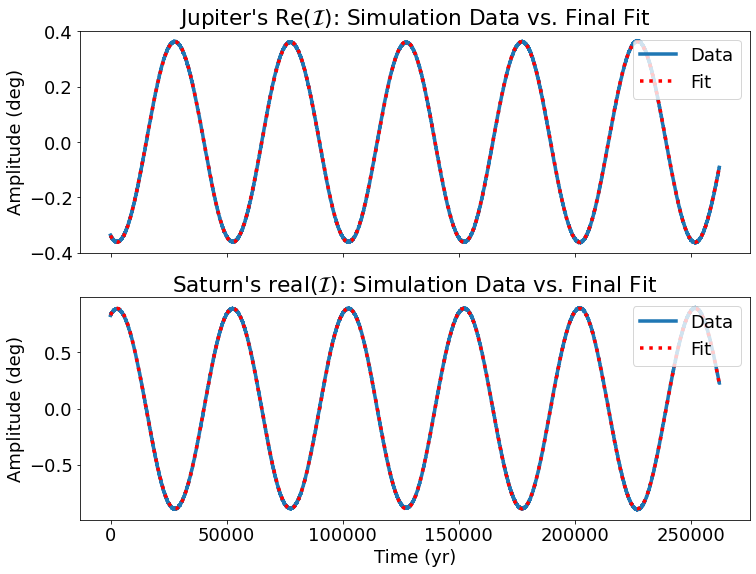

In [18]:
## Plot data vs. symfit results.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,9))
fig.patch.set_facecolor('white')

# Jupiter
j_series_fit = test_func(times, params['A11'], params['g1'], params['phi1'])

ax1.plot(times, j_series, lw='3.5', label='Data')
ax1.plot(times, j_series_fit, 'r:', lw='3.5', label='Fit')
#ax1.set_xlabel('Time (yr)')
ax1.set_ylabel('Amplitude (deg)')
ax1.set_title("Jupiter's Re($\mathcal{I}$): Simulation Data vs. Final Fit")
ax1.legend(loc='upper right')

# Saturn
s_series_fit = test_func(times, params['A21'], params['g1'], params['phi2'])

ax2.plot(times, s_series, lw='3.5', label='Data')
ax2.plot(times, s_series_fit, 'r:', lw='3.5', label='Fit')
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel('Amplitude (deg)')
ax2.set_title("Saturn's real($\mathcal{I}$): Simulation Data vs. Final Fit")
ax2.legend(loc='upper right')

fig_path = "Figures/JS_data_vs_symfit"
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

## Apply `curve_fit` (alternative to symfit)

In [ ]:
# Use curve_fit to infer the parameters of Jupiter's complex inclination 
# series (real component).
guess_j = [j_amp, 2*np.pi*j_freq, -np.pi/2]
params, params_covariance = optimize.curve_fit(test_func, times, j_series,
                                               p0=guess_j)
print(f'Jupiter params: {params}')
a_j, b_j, c_j = params

## Apply curve_fit to Saturn.
guess_s = [s_amp, 2*np.pi*s_freq, np.pi/2]
params, params_covariance = optimize.curve_fit(test_func, times, s_series,
                                               p0=guess_s)
print(f'Saturn params: {params}')
a_s, b_s, c_s = params

In [ ]:
## Plot data vs. curve_fit results.
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,9))
fig.patch.set_facecolor('white')

# Jupiter
ax1.plot(times, j_series, label='Data')
ax1.plot(times, test_func(times, a_j, b_j, c_j), 'r:', lw='3', label='Fit')
#ax1.set_xlabel('Time (yr)')
ax1.set_ylabel('Amplitude (deg)')
ax1.set_title("Jupiter's Re($\mathcal{I}$): Simulation Data vs. Final Fit")
ax1.legend(loc='upper right')

# Saturn
ax2.plot(times, s_series, label='Data')
ax2.plot(times, test_func(times, a_s, b_s, c_s), 'r:', lw='3', label='Fit')
ax2.set_xlabel('Time (yr)')
ax2.set_ylabel('Amplitude (deg)')
ax2.set_title("Saturn's real($\mathcal{I}$): Simulation Data vs. Final Fit")
ax2.legend(loc='upper right')

fig_path = "Figures/JS_data_vs_curvefit"
plt.savefig(fig_path, bbox_inches='tight')
plt.show()